# Sentiment Analysis using Recurrent Neural Network


Original Notebook in tensorflow  by Sujatha Subramanian  (https://github.com/SujathaSubramanian/Projects/blob/master/SentimentalAnalysis/USAirlineSentimentAnalysis/TwitterUSAirlineSentimentAnalysis.ipynb)


We will use a Kaggle Dataset (https://www.kaggle.com/crowdflower/twitter-airline-sentiment) for analyzing sentiments on US Airline Twitter Data.The model will be trained using LSTMs in TensorFlow.


In [1]:
from __future__ import print_function
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
from sklearn.model_selection import train_test_split
import numpy
import re
import nltk
from nltk.corpus import stopwords
import numpy as np

In [2]:
Tweet = pandas.read_csv("Tweets.csv")

## Data preprocessing

Pre-process the data by keeping only the text data(without special characters),removing stop words and extracting only meaningful words. Once the data is clean, build the word corpus based on the given data

In [3]:
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z@]", " ", raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))  
    meaningful_words = [w for w in words if not w in stops and not re.match("^[@]", w) and not re.match("flight",w)] 
    return( " ".join( meaningful_words )) 


In [4]:
#Pre-process the tweet and store in a separate column
Tweet['clean_tweet'] = Tweet['text'].apply(lambda x: tweet_to_words(x))
#Convert sentiment to binary
Tweet['sentiment'] = Tweet['airline_sentiment'].apply(lambda x: 0 if x == 'negative' else 1 if x == 'positive' else 2)

#Join all the words in review to build a corpus
all_text = ' '.join(Tweet['clean_tweet'])
words = all_text.split()

In [5]:
# Convert words to integers
from collections import Counter
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

tweet_ints = []
for each in Tweet['clean_tweet']:
    tweet_ints.append([vocab_to_int[word] for word in each.split()])

#Create a list of labels 
labels = np.array(Tweet['sentiment'])

In [6]:
#Find the number of tweets with zero length after the data pre-processing
tweet_len = Counter([len(x) for x in tweet_ints])
print("Zero-length reviews: {}".format(tweet_len[0]))
print("Maximum review length: {}".format(max(tweet_len)))

#Remove those tweets with zero length and its correspoding label 
tweet_idx  = [idx for idx,tweet in enumerate(tweet_ints) if len(tweet) > 0]
labels = labels[tweet_idx]
Tweet = Tweet.iloc[tweet_idx]
tweet_ints = [tweet for tweet in tweet_ints if len(tweet) > 0]

Zero-length reviews: 34
Maximum review length: 22


Create a feature matrix such that integers are arranged from right to left with leading zeroes.

In [7]:
seq_len = max(tweet_len)
features = np.zeros((len(tweet_ints), seq_len), dtype=int)
for i, row in enumerate(tweet_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]

## Training, Validation, Test



Split the data into training, validation, and test sets.


In [55]:
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

print("Train set: \t\t{}".format(train_y.shape), 
      "\nValidation set: \t{}".format(val_y.shape),
      "\nTest set: \t\t{}".format(test_y.shape))

			Feature Shapes:
Train set: 		(11684, 22) 
Validation set: 	(1461, 22) 
Test set: 		(1461, 22)
Train set: 		(11684,) 
Validation set: 	(1461,) 
Test set: 		(1461,)


## Build the graph

### Define Hyper-Parameters

lstm_size - Number of units in the hidden layers in the LSTM cells
lstm_layers - Number of LSTM layers in the network. Start with 1, then add more if underfitting
batch_size- The number of tweets to feed the network in one training pass. Typically this should be set as high as you can go without running out of memory.
learning_rate: Learning rate

### Perform Embedding
Converting words to the continuous vector space

### Build the LSTM cells
Using the hyper paramter lstm_size,lstm_layers LSTM cells are added to he graph

### Training and validation in batches
Once the graph is defined, training can be done in batches based on the batch_size hyper parameter.Models trains to improve the accuracy of the prediction.


In [88]:
lstm_size = 128
batch_size = 20
learning_rate = 0.001

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM
from keras.optimizers import RMSprop, SGD
from keras.utils import np_utils

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 740M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)


In [89]:
model = Sequential()
model.add(Embedding(len(tweet_ints), lstm_size))
#model.add(LSTM(lstm_size, implementation=0, return_sequences=True, dropout=0.2))
model.add(LSTM(lstm_size, implementation=2, dropout=0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

optimizer = SGD(lr=learning_rate, momentum=0.95)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Training



In [97]:
epochs = 25

train_y_c = np_utils.to_categorical(train_y, 3)
val_y_c = np_utils.to_categorical(val_y, 3)

model.fit(train_x, train_y_c,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_x, val_y_c), 
              class_weight={0:5, 1:3.0, 2:1.0})


Train on 11684 samples, validate on 1461 samples
Epoch 1/25
11684/11684 [==============================] - 12s - loss: 0.8672 - acc: 0.7968 - val_loss: 0.6941 - val_acc: 0.7639

## Testing
For the tweets in test set, predict the sentiment using the trained model 

In [98]:
test_y_c = np_utils.to_categorical(test_y, 3)
score, acc = model.evaluate(test_x, test_y_c,
                            batch_size=batch_size)
print()
print(acc)
    

1360/1461 [==========================>...] - ETA: 0s
0.828199864739


In [99]:
##Use the tweet sentiment predicted for the data in the test set,for plotting the wordcloud
test_pred = model.predict_classes(test_x)
test_pred_flat = (np.array(test_pred)).flatten()
start_idx = len(train_x) + len(val_x)
end_idx = start_idx + len(test_pred_flat)+1
Tweet.loc[start_idx:end_idx,'predicted_sentiment'] = test_pred_flat


1408/1461 [===========================>..] - ETA: 0s

In [100]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test_y, test_pred))
print(classification_report(test_y, test_pred))

[[1040   29   56]
 [  28   95   14]
 [ 107   17   75]]
             precision    recall  f1-score   support

          0       0.89      0.92      0.90      1125
          1       0.67      0.69      0.68       137
          2       0.52      0.38      0.44       199

avg / total       0.82      0.83      0.82      1461



## Word Cloud Visualization

For all the tweets in test set, split into positive and negative tweets.For the postive tweets, compare with the tweets that are predicted as positive using WordCloud. Similary, for the negative tweets compare with the tweets that are predicted as negative using WordCloud.

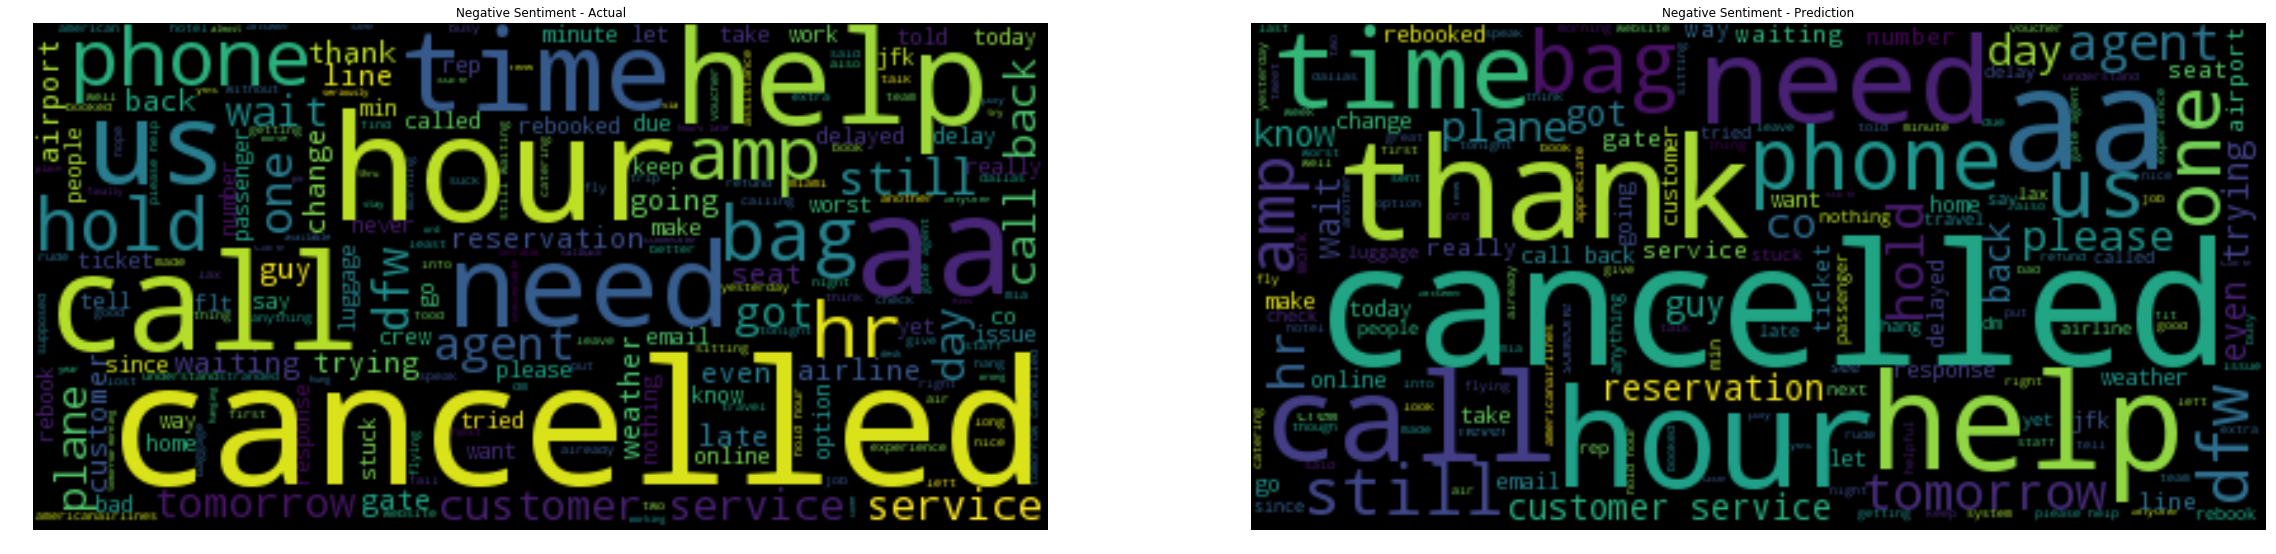

In [94]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

##Find all the tweets with actual sentiment as "Positive"
start_idx = len(train_x) + len(val_x)
test_tweets = Tweet[start_idx:]

fig = plt.figure( figsize=(40,40))
sub1= fig.add_subplot(2,2,1)

posActualTweets = test_tweets[test_tweets.sentiment==0]
posPredTweets = test_tweets[test_tweets.predicted_sentiment==0]

tweetText = ' '.join((posActualTweets['clean_tweet']))
# Generate a word cloud image
wordcloud = WordCloud().generate(tweetText)
plt.title("Negative Sentiment - Actual")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

sub2= fig.add_subplot(2,2,2)
plt.title("Negative Sentiment - Prediction")

tweetText = ' '.join((posPredTweets['clean_tweet']))
wordcloud = WordCloud().generate(tweetText)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


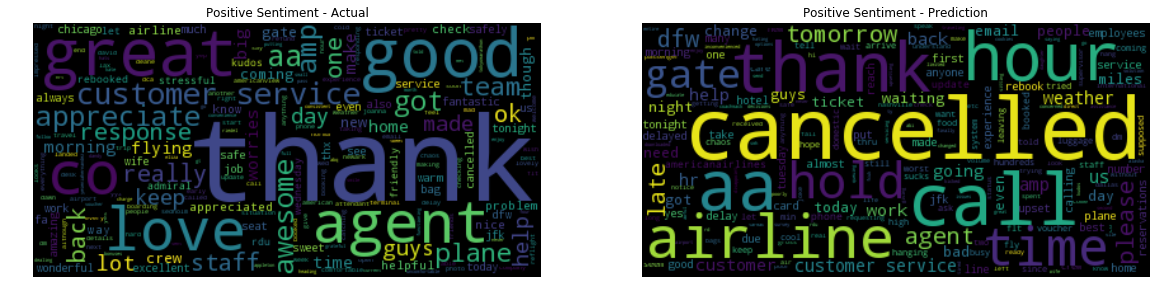

In [95]:
negActualTweets = test_tweets[test_tweets.sentiment==1]
negPredTweets = test_tweets[test_tweets.predicted_sentiment==1]

tweetText = ' '.join((negActualTweets['clean_tweet']))

fig = plt.figure( figsize=(20,20))
sub1= fig.add_subplot(2,2,1)
# Generate a word cloud image
wordcloud = WordCloud().generate(tweetText)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Positive Sentiment - Actual")
plt.axis("off")

sub2= fig.add_subplot(2,2,2)
tweetText = ' '.join((negPredTweets['clean_tweet']))
wordcloud = WordCloud().generate(tweetText)
plt.title("Positive Sentiment - Prediction")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

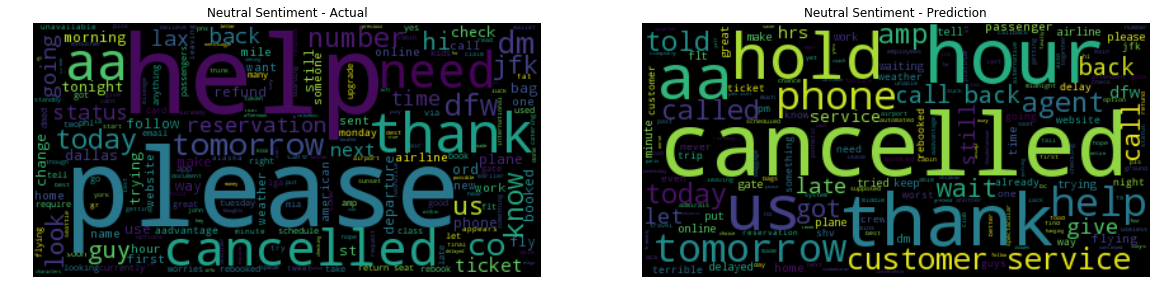

In [96]:
negActualTweets = test_tweets[test_tweets.sentiment==2]
negPredTweets = test_tweets[test_tweets.predicted_sentiment==2]

tweetText = ' '.join((negActualTweets['clean_tweet']))

fig = plt.figure( figsize=(20,20))
sub1= fig.add_subplot(2,2,1)
# Generate a word cloud image
wordcloud = WordCloud().generate(tweetText)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Neutral Sentiment - Actual")
plt.axis("off")

sub2= fig.add_subplot(2,2,2)
tweetText = ' '.join((negPredTweets['clean_tweet']))
wordcloud = WordCloud().generate(tweetText)
plt.title("Neutral Sentiment - Prediction")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Conclusion
Model achieved a test accuracy of .838. By looking at the word cloud, for postive and negative tweets the current model appears to be more closely predicting negative tweets than positive tweets.